<a href="https://colab.research.google.com/github/LeonimerMelo/GANs/blob/main/CIFAR10_DCGAN_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CIFAR10 DCGAN Example

Generative Adversarial Networks, or GANs, are an architecture for training generative models, such as deep convolutional neural networks for generating images.

Developing a GAN for generating images requires both a discriminator convolutional neural network model for classifying whether a given image is real or generated and a generator model that uses inverse convolutional layers to transform an input to a full two-dimensional image of pixel values.

It can be challenging to understand both how GANs work and how deep convolutional neural network models can be trained in a GAN architecture for image generation. A good starting point for beginners is to practice developing and using GANs on standard image datasets used in the field of computer vision, such as the CIFAR small object photograph dataset. Using small and well-understood datasets means that smaller models can be developed and trained quickly, allowing focus to be put on the model architecture and image generation process itself.

<center><img src="https://miro.medium.com/max/1280/1*Mw2c3eY5khtXafe5W-Ms_w.jpeg" width=800></center>

In [ ]:
import numpy as np
from numpy import zeros, ones
from numpy.random import randn, randint
from matplotlib import pyplot as plt
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from keras import backend
import time
from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##CIFAR-10 Small Object Photograph Dataset
CIFAR is an acronym that stands for the Canadian Institute For Advanced Research and the CIFAR-10 dataset was developed along with the CIFAR-100 dataset (covered in the next section) by researchers at the CIFAR institute.

The dataset is comprised of 60,000 32×32 pixel color photographs of objects from 10 classes, such as frogs, birds, cats, ships, airplanes, etc.

These are very small images, much smaller than a typical photograph, and the dataset is intended for computer vision research.

Keras provides access to the CIFAR10 dataset via the `cifar10.load_dataset()` function. It returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset.

In [ ]:
# Load CIFAR10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('min:', X_train.min(), 'max:', X_train.max())

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
min: 0 max: 255


In [ ]:
# Function to visualize random Training Images
def show_dataset(X_train, y_train):
  # define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
  cifar10_labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  j = np.random.randint(len(X_train)-60)
  fig = plt.figure(figsize=(10,7))
  for i in range(60):
    ax = fig.add_subplot(6, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i+j])
    #ax.set_title("{} {}".format(cifar10_labels[y_train[i+j][0]], str(y_train[i+j])), size=7)
    ax.set_title("{}".format(cifar10_labels[int(y_train[i+j][0])]), size=7)
    plt.axis('off')
  #plt.tight_layout()
  plt.show()

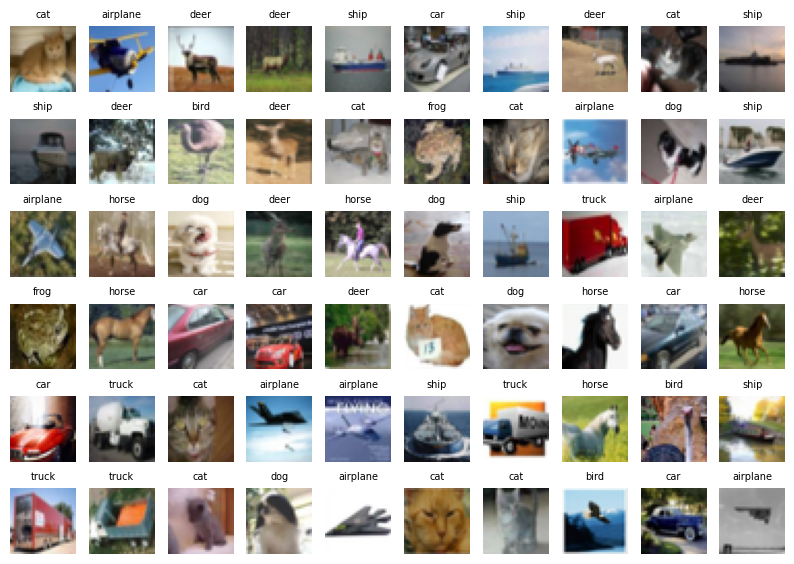

In [ ]:
# show random little part of dataset
show_dataset(X_train, y_train)

We will use the images in the training dataset as the basis for training a Generative Adversarial Network.

Specifically, the generator model will learn how to generate new plausible photographs of objects using a discriminator that will try and distinguish between real images from the CIFAR10 training dataset and new images output by the generator model.

This is a non-trivial problem that requires modest generator and discriminator models that are probably most effectively trained on GPU hardware.

In [ ]:
# Rotina para salvar o modelo da rede treinada (modelo, pesos e bias) para predições futuras sem ter que treiná-lo novamente
def model_save(model, name):
  mod = str(name)
  model_json = model.to_json()
  try:
    with open('/content/drive/MyDrive/Colab Notebooks/temp/model'+ mod +'.json','w') as json_file:
        json_file.write(model_json)
    model.save_weights('/content/drive/MyDrive/Colab Notebooks/temp/weights'+ mod + '.h5')
  except:
    print('drive canot be open to save files!')
    return

  print('Saved model ' + mod + ' to disk')

##The discriminator model
The discriminator model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake. This is a binary classification problem.

- **Inputs**: Image with three color channel and 32×32 pixels in size.
- **Outputs**: Binary classification, likelihood the sample is real (or fake).

The discriminator model has a normal convolutional layer followed by three convolutional layers using a stride of 2×2 to downsample the input image. The model has no pooling layers and a single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. The model is trained to minimize the binary cross entropy loss function, appropriate for binary classification.

We will use some best practices in defining the discriminator model, such as the use of LeakyReLU instead of ReLU, using Dropout, and using the Adam version of stochastic gradient descent with a learning rate of 0.0002 and a momentum of 0.5.

<center><img src="https://content.iospress.com/media/ifs/2021/41-2/ifs-41-2-ifs210843/ifs-41-ifs210843-g001.jpg?width=600"></center>

If you are creating many models in a loop, this global state will consume an increasing amount of memory over time, and you may want to clear it. Calling `clear_session()` releases the global state: this helps avoid clutter from old models and layers, especially when memory is limited.

In [ ]:
# Resets all state generated by Keras
backend.clear_session()

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32, 32, 3)):
    model = Sequential(name='Discriminator')
    # normal
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
# create the discriminator
d_model = define_discriminator()
# summarize the model
d_model.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)       

Running the example first summarizes the model architecture, showing the input and output from each layer.

We can see that the aggressive 2×2 stride acts to down-sample the input image, first from 32×32 to 16×16, then to 8×8 and more before the model makes an output prediction.

This pattern is by design as we do not use pooling layers and use the large stride to achieve a similar downsampling effect. We will see a similar pattern, but in reverse in the generator model.

###Load CIFAR10 dataset
We will use the cifar.load_data() function to load the CIFAR-10 dataset and just use the input part of the training dataset as the real images.

We must scale the pixel values from the range of unsigned integers in [0,255] to the normalized range of [-1,1].

The generator model will generate images with pixel values in the range [-1,1] as it will use the tanh activation function, a best practice. It is also a good practice for the real images to be scaled to the same range.

In [ ]:
# load cifar10 dataset and prepare cifar10 training images
# convert from unsigned ints to floats
X = np.concatenate([X_train, X_test])
X = X.astype('float32')
#X = X_train.astype('float32')
# scale from [0,255] to [-1,1]
dataset = (X - 127.5) / 127.5
print('dataset shape:', dataset.shape)
print('min:', dataset.min(), 'max:', dataset.max())

dataset shape: (60000, 32, 32, 3)
min: -1.0 max: 1.0


###Real samples
The model will be updated in batches, specifically with a collection of real samples and a collection of generated samples. On training, an epoch is defined as one pass through the entire training dataset.

We could systematically enumerate all samples in the training dataset, and that is a good approach, but good training via stochastic gradient descent requires that the training dataset be shuffled prior to each epoch. A simpler approach is to select random samples of images from the training dataset.

The `generate_real_samples()` function below will take the training dataset as an argument and will select a random subsample of images; it will also return class labels for the sample, specifically a class label of 1, to indicate real images.

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

###Source of fake images
We don’t have a generator model yet, so instead, we can generate images comprised of random pixel values, specifically random pixel values in the range [0,1], then scaled to the range [-1, 1] like our scaled real images.

The `generate_fake_samples()` function below implements this behavior and generates images of random pixel values and their associated class label of 0, for fake.

We can update the `generate_fake_samples()` function from the previous section to take the generator model as an argument and use it to generate the desired number of samples by first calling the `generate_latent_points()` function to generate the required number of points in latent space as input to the model.

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input, verbose=0)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

##The generator model
The generator model is responsible for creating new, fake, but plausible small photographs of objects. It does this by taking a point from the latent space as input and outputting a square color image.

The latent space is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space, CIFAR-10 images, that only the generator knows how to turn into plausible CIFAR-10 images.

- **Inputs**: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
- **Outputs**: Two-dimensional square color image (3 channels) of 32 x 32 pixels with pixel values in [-1,1].

Note: we don’t have to use a 100 element vector as input; it is a round number and widely used, but I would expect that 10, 50, or 500 would work just as well.

Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 32 x 32 x 3, or 3,072 values. There are a number of ways to achieve this, but there is one approach that has proven effective on deep convolutional generative adversarial networks. It involves two main elements.

The first is a Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size (one quarter the area) of the output image would be 16x16x3, or 768 nodes, and an image one quarter the size (one eighth the area) would be 8 x 8 x 3, or 192 nodes.

With some experimentation, I have found that a smaller low-resolution version of the image works better. Therefore, we will use 4 x 4 x 3, or 48 nodes.

We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a pattern in convolutional neural networks where we have many parallel filters resulting in multiple parallel activation maps, called feature maps, with different interpretations of the input. We want the same thing in reverse: many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create, or generate. Therefore, the first hidden layer, the Dense, needs enough nodes for multiple versions of our output image, such as 256.


<center><img src="https://pic3.zhimg.com/v2-76005a6c36fe51baa2eea5cefc8baf2e_r.jpg" width=800></center>

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential(name='Generator')
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model

The next major architectural innovation involves upsampling the low-resolution image to a higher resolution version of the image. There are two common ways to do this upsampling process, sometimes called deconvolution. One way is to use an `UpSampling2D` layer (like a reverse pooling layer) followed by a normal Conv2D layer. The other and perhaps more modern way is to combine these two operations into a single layer, called a `Conv2DTranspose`. We will use this latter approach for our generator.

The `Conv2DTranspose` layer can be configured with a stride of (2×2) that will quadruple the area of the input feature maps (double their width and height dimensions). It is also good practice to use a kernel size that is a factor of the stride (e.g. double) to avoid a checkerboard pattern that can sometimes be observed when upsampling.

Again, we will use the LeakyReLU with a default slope of 0.2, reported as a best practice when training GAN models.

The output layer of the model is a Conv2D with three filters for the three required channels and a kernel size of 3×3 and ‘same‘ padding, designed to create a single feature map and preserve its dimensions at 32 x 32 x 3 pixels. A tanh activation is used to ensure output values are in the desired range of [-1,1], a current best practice.

In [ ]:
# define the size of the latent space
latent_dim = 100
# define the generator model
g_model = define_generator(latent_dim)
# summarize the model
g_model.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         524416    
 anspose)                                                        
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                              

Running the example summarizes the layers of the model and their output shape. We can see that, as designed, the first hidden layer has 4,096 parameters or 256 x 4 x 4, the activations of which are reshaped into 256 4 x 4 feature maps. The feature maps are then upscaled via the three Conv2DTranspose layers to the desired output shape of 32 x 32, until the output layer where three filter maps (channels) are created.

The first step is to generate new points in the latent space. We can achieve this by calling the randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian.

The array of random numbers can then be reshaped into samples, that is n rows with 100 elements per row. The `generate_latent_points()` function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

##Train the generator model
The weights in the generator model are updated based on the performance of the discriminator model. When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less. This defines the zero-sum or adversarial relationship between these two models.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that combines the generator and discriminator models. Specifically, a new **GAN model** can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

To be clear, we are not talking about a new third model, just a new logical model that uses the already-defined layers and weights from the standalone generator and discriminator models. Only the discriminator is concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a standalone manner on examples of each.

The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, *we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model* so that they can not be updated and overtrained on fake examples.

When training the generator via this logical GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. *Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real* (class 1).

##GAN model
We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating good fake samples.

Let’s make this concrete.

- **Inputs**: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
- **Outputs**: Binary classification, likelihood the sample is real (or fake).

The `define_gan()` function below takes as arguments the already-defined generator and discriminator models and creates the new, logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

The GAN model then uses the same binary cross entropy loss function as the discriminator and the efficient Adam version of stochastic gradient descent with the learning rate of 0.0002 and momentum of 0.5, recommended when training deep convolutional GANs.


<center><img src="https://developer.ibm.com/developer/default/articles/generative-adversarial-networks-explained/images/GANs.jpg" width=700></center>

In [ ]:
# define GAN model: the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential(name='GAN')
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  # model.compile(loss='binary_crossentropy', optimizer=opt)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  #model.compiled_metrics == None
  return model

**Making the discriminator not trainable is a clever trick** in the Keras API. The trainable property impacts the model after it is compiled. The discriminator model was compiled with trainable layers, therefore the model weights in those layers will be updated when the standalone model is updated via calls to the `train_on_batch()` function.

The discriminator model was then marked as not trainable, added to the GAN model, and compiled. In this model, the model weights of the discriminator model are not trainable and cannot be changed when the GAN model is updated via calls to the `train_on_batch()` function. This change in the trainable property does not impact the training of the standalone discriminator model.

In [ ]:
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 32, 32, 3)         1466115   
                                                                 
 Discriminator (Sequential)  (None, 1)                 522497    
                                                                 
Total params: 1988612 (7.59 MB)
Trainable params: 1466115 (5.59 MB)
Non-trainable params: 522497 (1.99 MB)
_________________________________________________________________


Training the composite model involves generating a batch worth of points in the latent space via the `generate_latent_points()` function in the previous section, and class=1 labels and calling the `train_on_batch()` function.

The `train()` function below demonstrates this, although it is pretty simple as only the generator will be updated each epoch, leaving the discriminator with default model weights.

Instead, what is required is that we first update the discriminator model with real and fake samples, then update the generator via the composite model. This requires combining elements from the `train_discriminator()` function defined in the discriminator section above and the `train_gan()` function defined above. It also requires that we enumerate over both epochs and batches within in an epoch.

The complete train function for updating the discriminator model and the generator (via the composite model) is listed below. There are a few things to note in this model training function.

First, the number of batches within an epoch is defined by how many times the batch size divides into the training dataset. We have a dataset size of 50K samples, so with rounding down, there are 390 batches per epoch. The discriminator model is updated twice per batch, once with real samples and once with fake samples, which is a best practice as opposed to combining the samples and performing a single update.

Finally, we report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate. Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch. The generator loss is less critical and may hover between 0.5 and 2 or higher. **A clever programmer might even attempt to detect the crashing loss of the discriminator, halt, and then restart the training process.**

In [ ]:
# train the GAN: generator and discriminator
def train(g_model, d_model, gan_model, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  print('start GAN training')
  # manually enumerate epochs
  for i in range(n_epochs):
    t = time.time()
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss, _ = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      # if j % 100 == 0:
      #   print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i + 1, j + 1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # evaluate the model performance, sometimes
    if i == 0 or (i+1) % 3 == 0:
      display.clear_output(wait=True)
      print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f, elapsed time:%ds' % (i + 1, j + 1, bat_per_epo, d_loss1, d_loss2, g_loss, int(time.time()-t)))
      summarize_performance(i, g_model, d_model)

  print('end GAN training')

##Evaluate GAN Model Performance
Generally, there are no objective ways to evaluate the performance of a GAN model. We cannot calculate this objective error score for generated images. Instead, images must be subjectively **evaluated for quality by a human operator**. This means that we cannot know when to stop training without looking at examples of generated images. In turn, the adversarial nature of the training process means that the generator is changing after every batch, meaning that once “good enough” images can be generated, the subjective quality of the images may then begin to vary, improve, or even degrade with subsequent updates.

There are three ways to handle this complex training situation.
1. Periodically evaluate the classification accuracy of the discriminator on real and fake images.
2. Periodically generate many images and save them to file for subjective review.
3. Periodically save the generator model.

All three of these actions can be performed at the same time for a given training epoch, such as every 10 training epochs. The result will be a saved generator model for which we have a way of subjectively assessing the quality of its output and objectively knowing how well the discriminator was fooled at the time the model was saved.

Training the GAN over many epochs, such as hundreds or thousands of epochs, will result in many snapshots of the model that can be inspected, and from which specific outputs and models can be cherry-picked for later use.

First, we can define a function called `summarize_performance()` that will summarize the performance of the discriminator model. It does this by retrieving a sample of real CIFAR-10 images, as well as generating the same number of fake CIFAR-10 images with the generator model, then evaluating the classification accuracy of the discriminator model on each sample, and reporting these scores.

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real * 100, acc_fake * 100))
    # save plot
    plot_img(x_fake, epoch)
    # save models and weigths
    model_save(g_model, 'Generator')
    model_save(d_model, 'Discriminator')
    model_save(gan_model, 'GAN')

As we are evaluating the discriminator on 100 generated CIFAR-10 images, we can plot about half, or 49, as a 7 by 7 grid. The `plot_img()` function below implements this, again saving the resulting plot with a unique filename based on the epoch number.

In [ ]:
# create a plot of generated images
def plot_img(examples, epoch):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    fig = plt.figure(figsize=(9,6))
    # plot images
    l = 5
    c = 8
    for i in range(l * c):
        # define subplot
        plt.subplot(l, c, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

The chosen configuration results in the stable training of both the generative and discriminative model. The model performance is reported every batch, including the loss of both the discriminative (d) and generative (g) models.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

In this case, the loss remains stable over the course of training. The discriminator loss on the real and generated examples sits around 0.5, whereas the loss for the generator trained via the discriminator sits around 1.5 for much of the training process.

In [ ]:
# train model
epochs = 2
batch_size = 128
train(g_model, d_model, gan_model, epochs, batch_size)

start GAN training


KeyboardInterrupt: 

In [ ]:
# rotina para carregar os modelos das redes treinadas (modelo, pesos e bias)
# para predições futuras sem ter que treiná-lo novamente ou para reiniciar os treinamentos
def load_model(name):
  mod = str(name)
  try:
    # Load json and create model
    j_file = open('/content/drive/MyDrive/Colab Notebooks/temp/model'+ mod +'.json','r')
  except:
    print('file does not exist or drive is not open!')
    return

  load_model_json = j_file.read()
  j_file.close()
  loaded_model=model_from_json(load_model_json)
  try:
    # Load weights into new model
    loaded_model.load_weights('/content/drive/MyDrive/Colab Notebooks/temp/weights'+ mod + '.h5')
  except:
    print('file does not exist or drive is not open!')
    return

  print('Loaded model ' + mod + ' from disk')
  return loaded_model

In [ ]:
# carrego os modelos treinados
g_model = load_model('Generator')
d_model = load_model('Discriminator')
gan_model = load_model('GAN')

Loaded model Generator from disk
Loaded model Discriminator from disk
Loaded model GAN from disk


In [ ]:
def compile_discr(model):
  # compile model discriminator
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

def compile_gan(model):
  # compile model gan
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
compile_discr(d_model)
compile_gan(gan_model)

In [ ]:
# função para gerar as imagens fake com as pedições
def plot_generated_images(examples=50):
  noise = np.random.normal(0, 1, size=[examples, latent_dim])
  generated_images = g_model.predict(noise, verbose='None')
  discr_predict = d_model.predict(generated_images, verbose='None')
  gen_images = generated_images.reshape(examples, 32, 32, 3)
  # scale from [-1,1] to [0,1]
  gen_images = (gen_images + 1) / 2.0
  dim=(10, 10)
  plt.figure(figsize=(10, 12))
  for i in range(gen_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(gen_images[i])
    a=discr_predict[i][0]
    fo = "{:.2f}".format(a)
    plt.title(str(fo), size=8)
    plt.axis('off')
  #plt.tight_layout()

In [ ]:
# # função para plotar as imagens reais com as pedições
def plot_real_images(examples=50):
  X_real, _ = generate_real_samples(dataset, examples)
  discr_predict = d_model.predict(X_real, verbose='None')
  # scale from [-1,1] to [0,1]
  X_real = (X_real + 1) / 2.0
  dim=(10, 10)
  plt.figure(figsize=(10, 12))
  for i in range(X_real.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(X_real[i])
    a=discr_predict[i][0]
    fo = "{:.2f}".format(a)
    plt.title(str(fo), size=8)
    plt.axis('off')
  #plt.tight_layout()

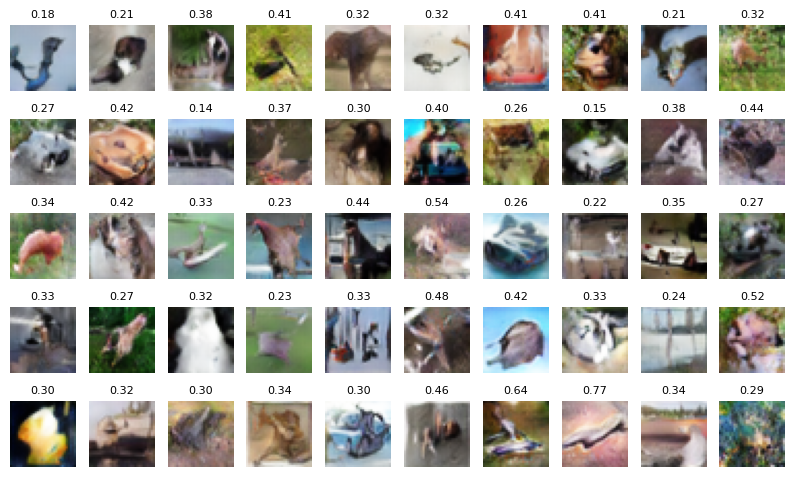

In [ ]:
plot_generated_images()

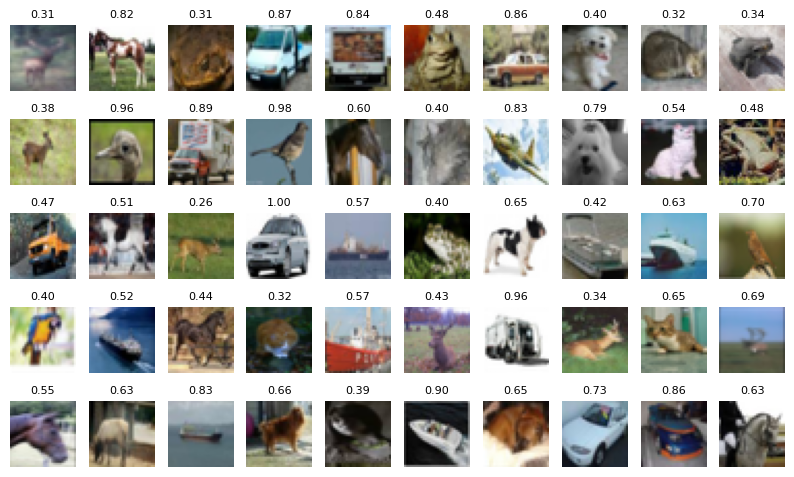

In [ ]:
plot_real_images()

##Referências

[1] [How to Develop a GAN to Generate CIFAR10](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

[2] https://www.tensorflow.org/tutorials/generative/dcgan

[3] https://pyimagesearch.com/2020/11/16/gans-with-keras-and-tensorflow/

[4] https://github.com/tensorflow/gan

[5] https://blog.paperspace.com/implementing-gans-in-tensorflow/

[6] https://pyimagesearch.com/2020/11/16/gans-with-keras-and-tensorflow/

##Exercícios
1. Change Latent Space. Update the example to use a larger or smaller latent space and compare the quality of the results and speed of training.
1. Batch Normalization. Update the discriminator and/or the generator to make use of batch normalization, recommended for DCGAN models.
1. Label Smoothing. Update the example to use one-sided label smoothing when training the discriminator, specifically change the target label of real examples from 1.0 to 0.9 and add random noise, then review the effects on image quality and speed of training.
1. Model Configuration. Update the model configuration to use deeper or more shallow discriminator and/or generator models, perhaps experiment with the UpSampling2D layers in the generator.
1. Modificar a estrutura da rede para deixá-la menos densa, retirandando algumas camadas do gerador e do discriminador. Verificar os resultados nos tempos de treinamento e na acurácia.
1. Compare the results and try to find the best architecture for the dataset used.
1. Utilizar outros bancos de imagens como dataset e comparar os resultados.